In [103]:
import random
import numpy as np
import torch
import torch.amp
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader
from torchvision.models import ResNet152_Weights, resnet152

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from matplotlib import pyplot as plt

In [104]:
"""Define the model"""
class ResidualBlock(nn.Module):
    """Residual block for the decoder to mirror ResNet architecture"""
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection to match dimensions
        self.shortcut = (
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            ) if stride != 1 or in_channels != out_channels else nn.Identity()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        
        out = F.silu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = F.silu(out)
        
        return out


class DecoderBlock(nn.Module):
    """Enhanced decoder block with residual connections"""
    def __init__(self, in_channels: int, out_channels: int, stride: int = 2):
        super().__init__()
        self.conv_transpose = nn.ConvTranspose2d(
            in_channels, out_channels,
            kernel_size=4, stride=stride,
            padding=1, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.residual = ResidualBlock(out_channels, out_channels)
        self.activation = nn.SiLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_transpose(x)
        x = self.bn(x)
        x = self.activation(x)
        x = self.residual(x)
        return x


class ResNetAutoencoder(nn.Module):
    def __init__(self, 
                 emb_dim: int = 2056,
                 input_channels: int = 1,
                 dropout_rate: float = 0.1):
        super().__init__()
        
        self.emb_dim = emb_dim
        
        # Encoder (modified ResNet-18)
        self.encoder = resnet152(ResNet152_Weights)
        
        # Modify first layer for different input channels
        self.encoder.conv1 = nn.Conv2d(
            input_channels, 64, kernel_size=7,
            stride=2, padding=3, bias=False
        )    
    
        self.encoder.fc = nn.Sequential(
            nn.Linear(self.encoder.fc.in_features, emb_dim),
            nn.LayerNorm(emb_dim),
            nn.Dropout(dropout_rate),
            nn.SiLU()
        )
    
        # Projection from embedding to spatial features
        self.proj = nn.Sequential(
            nn.Linear(emb_dim, 256 * 16 * 16),
            nn.LayerNorm(256 * 16 * 16),
            nn.Dropout(dropout_rate),
            nn.SiLU()
        )
        
        # Enhanced decoder with residual connections
        # Decoder with enhanced residuals
        self.decoder = nn.Sequential(
            DecoderBlock(256, 128),
            DecoderBlock(128, 64),
            DecoderBlock(64, 32),
            DecoderBlock(32, 16),
            nn.ConvTranspose2d(16, input_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
        self.initialize_weights()

    def initialize_weights(self):
        """Initialize weights using kaiming normal initialization."""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode input to latent space"""
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        x = self.encoder.maxpool(x)

        x = self.encoder.layer1(x)
        x = self.encoder.layer2(x)
        x = self.encoder.layer3(x)
        x = self.encoder.layer4(x)

        x = self.encoder.avgpool(x)
        x = torch.flatten(x, 1)
        
        return self.encoder.fc(x)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decode latent representation back to image space"""
        x = self.proj(z)
        x = x.view(-1, 256, 16, 16)
        return self.decoder(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass with optional variational outputs"""
        z = self.encode(x)
        return self.decode(z)

    def get_loss(self, x: torch.Tensor) -> torch.Tensor:
        """Calculate loss"""
        recon_x = self(x)
        loss = F.binary_cross_entropy(recon_x, x)
        return loss
        

In [95]:
"""Define the dataset"""
from pathlib import Path
import pydicom
import cv2 as cv




class RSNADataSet(torch.utils.data.Dataset):
    def __init__(self, train = True, split=0.9):
        
        self.imgs = [img for img in Path("train_images").glob("**/*.dcm")]
        if train:
            self.imgs = self.imgs[:int(len(self.imgs)*split)]
        else:
            self.imgs = self.imgs[int(len(self.imgs)*(split)):]
          
        self.imgs = [self.transform_img(img) for img in self.imgs]
          
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx]
    
    @staticmethod
    def transform_img(path: Path, desired_shape=(256, 256)):
      with pydicom.dcmread(path) as img:
        H, W = img.pixel_array.shape

        res_img = np.zeros(desired_shape, dtype=img.pixel_array.dtype)
        if W > H:
          new_H = int(desired_shape[0] * (H / W))
          pad_top = (desired_shape[0] - new_H) // 2
          cv.resize(img.pixel_array, (desired_shape[0], new_H), dst=res_img[pad_top:pad_top + new_H,  :] )
        elif H > W:
          new_W = int(desired_shape[1] * (W / H))
          pad_left = (desired_shape[1] - new_W) // 2
          cv.resize(img.pixel_array, (new_W, desired_shape[1]), dst=res_img[:, pad_left:pad_left + new_W])
        else:
          cv.resize(img.pixel_array, desired_shape, dst=res_img)
      
      # min max normalization 
      res_img = res_img - res_img.min()
      res_img = res_img / res_img.max()
      return torch.from_numpy(res_img).to(dtype=torch.bfloat16).unsqueeze(0)



In [7]:
random.seed(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [96]:
"""Loading dataset
This will take ~42 minutes, use the cell below to load the datasets directly from binary files
"""  
train_dataset = RSNADataSet(train=True)
test_dataset = RSNADataSet(train=False)

print(f"Loaded datasets train: {len(train_dataset)}, test: {len(test_dataset)} entries")

Loaded datasets train: 132496, test: 14722 entries


In [116]:
"""Save datasets"""

def split_list(lst, chunk_size):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]


train_split = split_list(train_dataset, len(train_dataset) // 9 + 1)
for i, lst in enumerate(train_split):
    torch.save(lst, f"data/train_dataset_{i}.pt")

# torch.save(test_dataset, "data/test_dataset.pt")

In [102]:
"""Loading dataset form binary files (much faster)"""
train_dataset = torch.load("data/train_dataset.pt", weights_only=False)
test_dataset = torch.load("data/test_dataset.pt", weights_only=False)

In [ ]:
"""Create model from scratch"""
model = ResNetAutoencoder(2056 * 2)

In [17]:
"""Load model from checkpoint"""
model = torch.load("models/autoencoder.pt", weights_only=False)

In [106]:
"""Compile model"""
model = model.to(DEVICE).to(dtype=torch.bfloat16)
print(f"Current model has {sum(p.element_size() * p.nelement() for p in model.parameters()) / (2**30):.3f}GB parameters")

Current model has 0.628GB parameters


In [107]:
"""Keep track of train parameters"""
train_losses = list()
test_losses = list()
train_norms = list()

In [ ]:
"""Training loop"""
EPOCHS = 1
LR = 3e-4
TEST_INTERVALL = 200
BS = 64

train_dataloader = torch.utils.data.dataloader.DataLoader(
  train_dataset, 
  batch_size=BS, 
  shuffle=True, 
  num_workers=1,
  prefetch_factor=2,
  pin_memory=True, 
  persistent_workers=True,
  drop_last=True
)

test_dataloader = torch.utils.data.dataloader.DataLoader(test_dataset, batch_size=BS, pin_memory=True)


opt = torch.optim.AdamW(model.parameters(), lr=LR)


print("Starting training run")

# Total number of steps (epochs * iterations)
total_steps = EPOCHS * len(train_dataloader)

# Single progress bar
pbar = tqdm(total=total_steps, desc='Training')

i = 0
train_loss = 0
test_loss = 0
train_norm = 0

model.train()
for n_epoch in range(EPOCHS):
    intervall_loss = list()
    intervall_norm = list()
    for batch in train_dataloader:
        batch = batch.to(DEVICE)
        opt.zero_grad()
        loss = model.get_loss(batch)
        
        loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        opt.step()
        intervall_loss.append(loss.item())
        intervall_norm.append(norm.item())
        
        if i % TEST_INTERVALL == 0 and i:
            model.eval()
            with torch.no_grad():
                losses = list()
                for batch in test_dataloader:
                    batch = batch.to(DEVICE)
                    loss = model.get_loss(batch)
                    losses.append(loss.item())

                test_loss = sum(losses) / len(losses)
                
                train_loss = sum(intervall_loss) / len(intervall_loss)
                intervall_loss.clear()

                train_norm = sum(intervall_norm) / len(intervall_norm)
                intervall_norm.clear()


                train_losses.append(train_loss)
                test_losses.append(test_loss)
                train_norms.append(train_norm)

            model.train()
        i += 1
        pbar.set_description(f'Epoch {n_epoch+1}, Iteration {i}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, train_norm {train_norm:.4f}', refresh=False)
        pbar.update(1)
torch.save(model, "models/autoencoder.pt")
pbar.close()

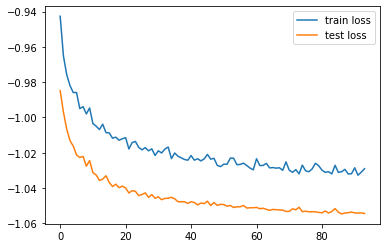

In [120]:
plt.plot(np.log(train_losses), label="train loss")
plt.plot(np.log(test_losses), label="test loss")
plt.legend()
plt.savefig("training")

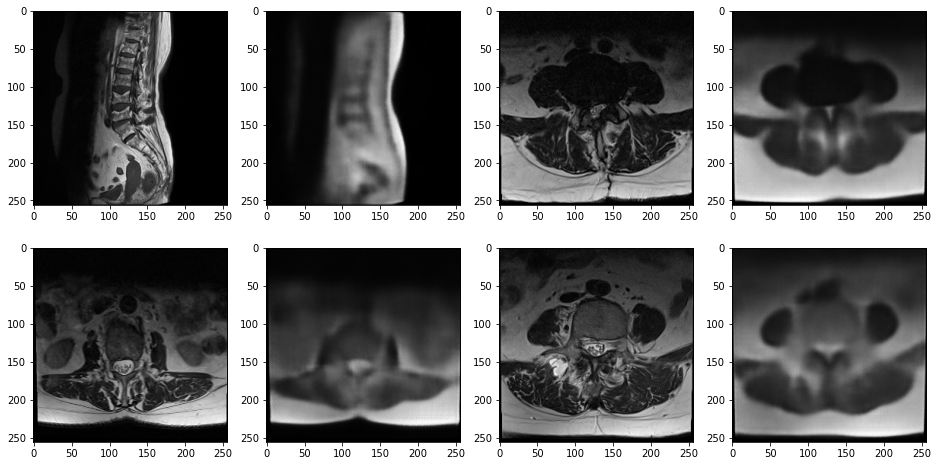

In [121]:
"""Visualize predictions"""
imgs = random.sample(test_dataset.imgs, 4)


data = torch.concat(imgs).unsqueeze(1)

data = data.to(DEVICE)

model.eval()
with torch.no_grad():
    pred : torch.Tensor = model(data)

plt.figure(figsize=(16, 8))
for i in range(len(imgs)):
    v_img = data[i].cpu().to(torch.float32).squeeze()
    v_pred = pred[i].cpu().to(torch.float32).squeeze()
    plt.subplot(2, 4, i * 2 + 1)
    plt.imshow(v_img, cmap="gray")
    plt.subplot(2, 4, i * 2 + 2)
    plt.imshow(v_pred, cmap="gray")

plt.show();

In [123]:
torch.save(model, "models/autoencoder.pt")